In [1]:
import tensorflow as tf
import numpy as np
import os
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import random
from sklearn.utils import shuffle

2024-02-06 22:26:46.563845: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-06 22:26:46.563943: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-06 22:26:46.732026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
TRAIN_PATH = '/kaggle/input/carvana-image-masking-png/train_images/'
MASKS_PATH = '/kaggle/input/carvana-image-masking-png/train_masks/'

IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [3]:
ids = next(os.walk(TRAIN_PATH))[2]

In [4]:
shuffle_data = shuffle(ids, random_state = 42)

In [5]:
test_len = len(shuffle_data)//10

In [6]:
test_ids = shuffle_data[:test_len]
train_ids = shuffle_data[test_len:]

In [7]:
len(test_ids)

508

In [8]:
len(train_ids)

4580

In [9]:
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype = bool)

In [10]:
for n, ide in tqdm(enumerate(train_ids), total=len(train_ids)):  
    
    id_ = ide.split(".")[-2]
    path = TRAIN_PATH + id_  
    
    img = imread(path + '.jpg')[:, :, :IMG_CHANNELS]  
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)  
    
    X_train[n] = img 
    
    mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=bool)  
    
    mask_path = MASKS_PATH + id_
    
    mask_ = imread(mask_path + ".png")

    mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True), axis=-1)

    mask = np.maximum(mask, mask_)
    
    Y_train[n] = mask

100%|██████████| 4580/4580 [48:55<00:00,  1.56it/s]


In [11]:
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)

sizes_test = []

for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):

    path = TRAIN_PATH + id_

    img = imread(path)[:, :, :IMG_CHANNELS]

    sizes_test.append([img.shape[0], img.shape[1]])

    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)

    X_test[n] = img

100%|██████████| 508/508 [03:58<00:00,  2.13it/s]


In [12]:
def conv_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(inputs)
    x = tf.keras.layers.Dropout(0.1)(x)
    x = tf.keras.layers.Conv2D(num_filters, (3, 3), activation="relu", 
                               kernel_initializer="he_normal", padding="same")(x)
    return x

def upsample_block(inputs, conv_prev, num_filters):
    up = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding="same")(inputs)
    concat = tf.keras.layers.concatenate([up, conv_prev])
    conv = conv_block(concat, num_filters)
    return conv

In [13]:
inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

s = tf.keras.layers.Lambda(lambda x: x/255.0)(inputs) 

c1 = conv_block(s, 16)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

c2 = conv_block(p1, 32)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

c3 = conv_block(p2, 64)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

c4 = conv_block(p3, 128)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

c5 = conv_block(p4, 256)

c6 = upsample_block(c5, c4, 128)
c7 = upsample_block(c6, c3, 64)
c8 = upsample_block(c7, c2, 32)
c9 = upsample_block(c8, c1, 16)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

In [14]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 128, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 16)         448       ['lambda[0][0]']              
                                                                                                  
 dropout (Dropout)           (None, 128, 128, 16)         0         ['conv2d[0][0]']              
                                                                                              

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience = 5, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
            ]

In [16]:
results = model.fit(
    X_train, 
    Y_train, 
    validation_split = 0.1, 
    batch_size = 16, 
    epochs = 25, 
    callbacks = callbacks)

Epoch 1/25


2024-02-06 23:20:14.437980: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1707261619.404388      72 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


258/258 [==============================] - 31s 60ms/step - loss: 0.1959 - accuracy: 0.9180 - val_loss: 0.0744 - val_accuracy: 0.9692
Epoch 2/25
258/258 [==============================] - 12s 46ms/step - loss: 0.0446 - accuracy: 0.9817 - val_loss: 0.0406 - val_accuracy: 0.9828
Epoch 3/25
258/258 [==============================] - 12s 46ms/step - loss: 0.0324 - accuracy: 0.9869 - val_loss: 0.0314 - val_accuracy: 0.9872
Epoch 4/25
258/258 [==============================] - 12s 46ms/step - loss: 0.0266 - accuracy: 0.9893 - val_loss: 0.0287 - val_accuracy: 0.9883
Epoch 5/25
258/258 [==============================] - 12s 46ms/step - loss: 0.0236 - accuracy: 0.9906 - val_loss: 0.0218 - val_accuracy: 0.9911
Epoch 6/25
258/258 [==============================] - 12s 47ms/step - loss: 0.0211 - accuracy: 0.9916 - val_loss: 0.0190 - val_accuracy: 0.9924
Epoch 7/25
258/258 [==============================] - 12s 47ms/step - loss: 0.0192 - accuracy: 0.9923 - val_loss: 0.0173 - val_accuracy: 0.9932
Epo

In [17]:
idx = random.randint(0, len(X_train))

preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose = 1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose = 1)
preds_test = model.predict(X_test, verbose = 1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

16/16 [==============================] - 2s 126ms/step


In [18]:
def display_images(image):
    plt.imshow(image)
    plt.axis('off')
    plt.show()

Input Image:


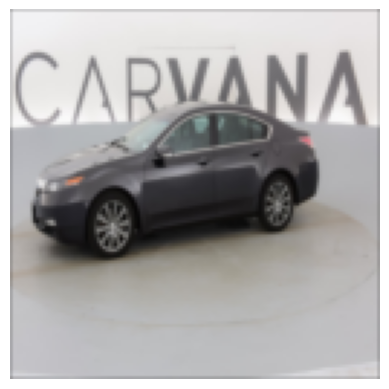

Ground Truth Mask:


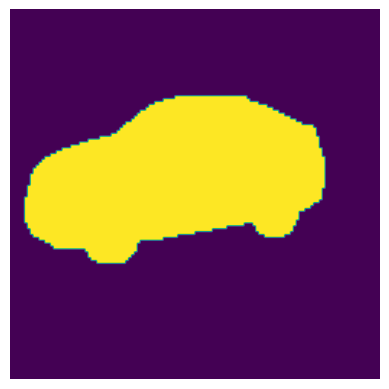

Predicted Mask:


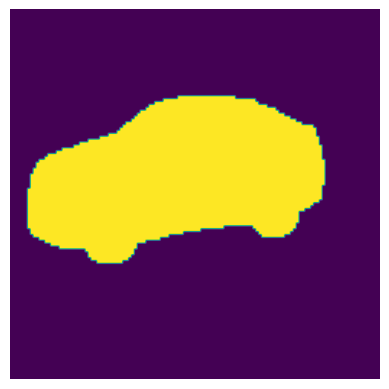

In [19]:
ix = random.randint(0, len(preds_train_t))

print("Input Image:")
display_images(X_train[ix])

print("Ground Truth Mask:")
display_images(np.squeeze(Y_train[ix]))

print("Predicted Mask:")
display_images(np.squeeze(preds_train_t[ix]))

Validation Input Image:


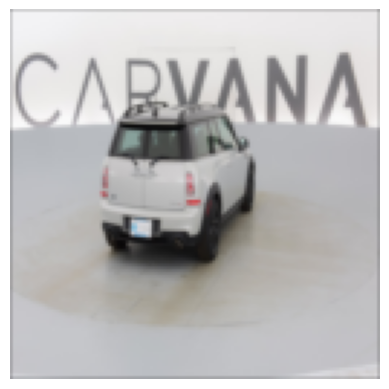

Validation Ground Truth Mask:


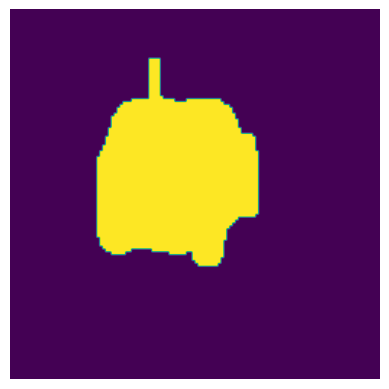

Validation Predicted Mask:


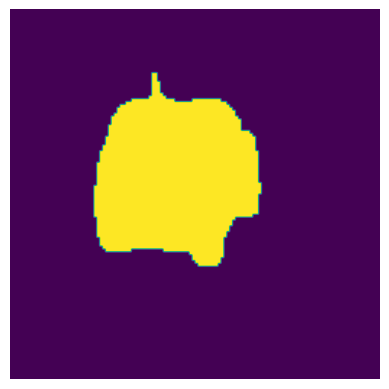

In [20]:
ix = random.randint(0, len(preds_val_t))

val_data_start = int(X_train.shape[0] * 0.9)

print("Validation Input Image:")
display_images(X_train[val_data_start:][ix])

print("Validation Ground Truth Mask:")
display_images(np.squeeze(Y_train[val_data_start:][ix]))

print("Validation Predicted Mask:")
display_images(np.squeeze(preds_val_t[ix]))